<a href="https://colab.research.google.com/github/AyushiM1102/Electra_classification_fake_vs_real_news/blob/main/bert_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install transformers

In [2]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [3]:
!git clone https://github.com/AyushiM1102/Electra_classification_fake_vs_real_news.git

fatal: destination path 'Electra_classification_fake_vs_real_news' already exists and is not an empty directory.


In [4]:
!unzip /content/Electra_classification_fake_vs_real_news/data/WELFake_Dataset.csv.zip -d /content/Electra_classification_fake_vs_real_news/dataset

Archive:  /content/Electra_classification_fake_vs_real_news/data/WELFake_Dataset.csv.zip
replace /content/Electra_classification_fake_vs_real_news/dataset/WELFake_Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/Electra_classification_fake_vs_real_news/dataset/__MACOSX/._WELFake_Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [5]:
datapath = f'/content/Electra_classification_fake_vs_real_news/dataset/WELFake_Dataset.csv'
df = pd.read_csv(datapath)
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [6]:
df["text"] = df["text"].astype(str)
df.text.dtype

dtype('O')

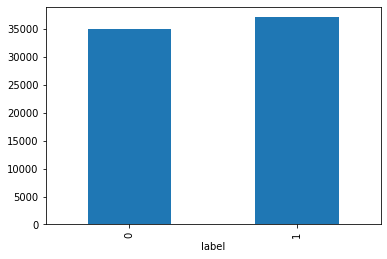

In [7]:
# Drop NaN and see class balance
df = df[df['label'].notna()]
df.groupby(['label']).size().plot.bar()

In [8]:
df.label[df.label == 0] = 'real'
df.label[df.label == 1] = 'fake'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'real':0,'fake':1}

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs

        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [10]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [11]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [12]:

def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              
              # Accuracy
              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

              # Precision = TruePositives / (TruePositives + FalsePositives)

              # Recall = TruePositives / (TruePositives + FalseNegatives)

              # F1 = ((precision * recall)/(precision + recall))
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [13]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

57707 7213 7214


In [14]:
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 28854/28854 [1:02:38<00:00,  7.68it/s]


Epochs: 1 | Train Loss:  0.044 | Train Accuracy:  0.973 | Val Loss:  0.018 | Val Accuracy:  0.989


100%|██████████| 28854/28854 [1:02:40<00:00,  7.67it/s]


Epochs: 2 | Train Loss:  0.007 | Train Accuracy:  0.996 | Val Loss:  0.013 | Val Accuracy:  0.993


100%|██████████| 28854/28854 [1:02:41<00:00,  7.67it/s]


Epochs: 3 | Train Loss:  0.002 | Train Accuracy:  0.999 | Val Loss:  0.013 | Val Accuracy:  0.994


100%|██████████| 28854/28854 [1:02:45<00:00,  7.66it/s]


Epochs: 4 | Train Loss:  0.001 | Train Accuracy:  1.000 | Val Loss:  0.012 | Val Accuracy:  0.995


100%|██████████| 28854/28854 [1:02:38<00:00,  7.68it/s]


Epochs: 5 | Train Loss:  0.000 | Train Accuracy:  1.000 | Val Loss:  0.016 | Val Accuracy:  0.995


In [15]:
evaluate(model, df_test)

Test Accuracy:  0.995
